<a href="https://www.kaggle.com/code/daiqing2009/ocr-performance-analysis-on-license-plates?scriptVersionId=175282226" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/daiqing2009/ocr-performance-analysis-on-license-plates?scriptVersionId=172543186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# OCR Performance Analysis on LICENSE PLATES
This notebook get hint of https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition, which utilized almost all the datasets in kaggle for license plate localization using YOLO. Similarly, we analyzed as many as datasets we can find in kaggle for license plate OCR:
* different scales of data(i.e. license plate images)
* different state-of-art OCR modules
* different (combination of) hardware


# License plate images Preparation



### Dataset Analysis

| Name | Number of picture(approximate) | Need Crop | Crop Method | Remark|
|--- | --- | --- | --- | --- |
|number-plate-detection| 250 | Y | coordinates in XML | high-resolution pic |
|car-plate - detection | 500 | Y | coordinates in XML | medium-resolution pic  |
|indian-vehicle-dataset|1,000 | Y | coordinates in XML | low-medium resolution pic, license plate no. in XML|
| stanford-cars-dataset|20,000 | Y | annotation in mat | details in mat file unknown |
| synthetic-turkish-license-plates | 100,000 | N | N/A | synthtic crated, license plate no. as file name |
| us-license-plates | 4,000 | N | N/A | high-resulution front-view license plates with states name/symbol |
| us-license-plates | 20,000 | N | N/A | low-medium resulution front-view license plates with states name/symbol |

Besides, there's a dataset called **license-plate-digits-classification-dataset** so enable us to train own number recognition NN if needed. Since threre're plenty of **front-view license plates pictures with no need to crop** , it is  reasonable to work on those before turn to those pictures needing crop. 

## Baseline TESSERACT OCR

Optical character recognition (OCR) software that is used to extract text from the image. Tesseract OCR have a python API and it is open source. Firstly, we will do installation of it. It pretty simple and depend on you OS. You can find manual and files to download for installation [here](https://guides.library.illinois.edu/c.php?g=347520&p=4121425).

### LIMITATIONS OF PYTESSERACT
Tesseract works best when there is a clean segmentation of the foreground text from the background. 

In practice, it can be **extremely challenging to guarantee these types of setups**. There are a variety of reasons you might not get good quality output from Tesseract like if the image has noise on the background. The better the image quality (size, contrast, lightning) the better the recognition result. It requires a bit of preprocessing to improve the OCR results, images need to be scaled appropriately, have as much image contrast as possible, and the text must be horizontally aligned. 

In [1]:
# contraint tensorflow GPU memory usage, otherwise it will consume all
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized


In [2]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=a78ed693d2900f8fafb53129edf29d81f0cc9bfe1a5d2d763cf7a91d3024da03
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


In [3]:
%%capture
!pip install opencv-python
!pip install matplotlib

In [4]:
%%capture
!pip install pytesseract

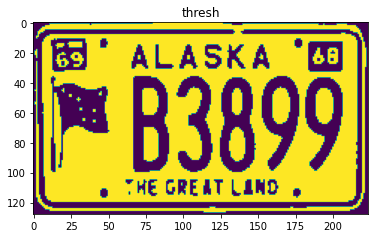

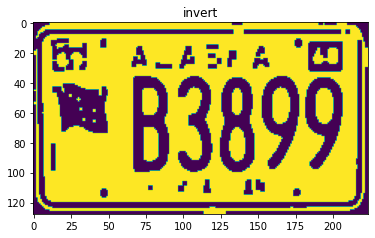

In [5]:
import pytesseract
import cv2
from matplotlib import pyplot as plt

path = "/kaggle/input/us-license-plates-image-classification/new plates/test/ALASKA/1.jpg"

image = cv2.imread(path)
def show_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.show()
    
def blur_thresh(image):
    # Grayscale, Gaussian blur, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh
thresh = blur_thresh(image)
invert = 255 - thresh
show_image(invert, 'thresh')

def denoise(image):
    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    return opening

opening = denoise(thresh)
invert = 255 - opening
show_image(invert, 'invert')

# Perform text extraction
config = ('-l eng --psm 6') # eng is English, psm 6 is for a single uniform block of text
data = pytesseract.image_to_string(invert, config=config)
print(data)


### Preprocess via Efficient and Accurate Scene Text(EAST) detection
Since tesseract relies heavily on the quality of preprocessing, one important technique is to find the bounding box of detected text. we utilize state-of-art EAST detection model belong to identify the bounding box of license plate number location and surrounding meaningful texts. 

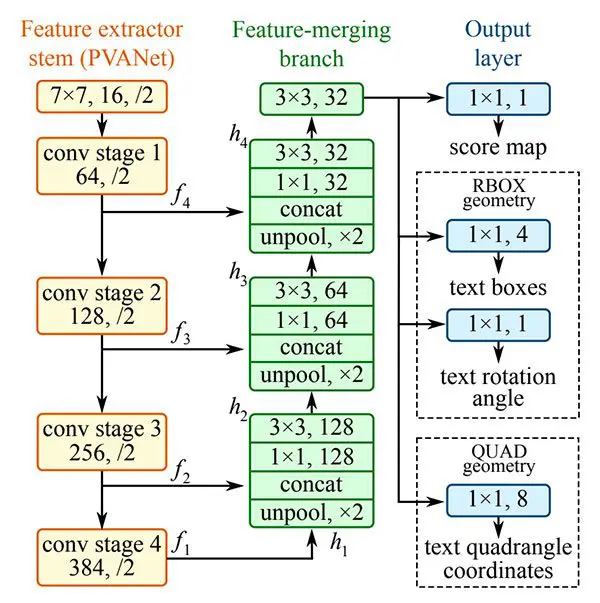

refer to 
https://pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/ for more details. 


In [6]:
%%capture
!pip install imutils

[INFO] loading EAST text detector...
[INFO] text detection took 0.367575 seconds


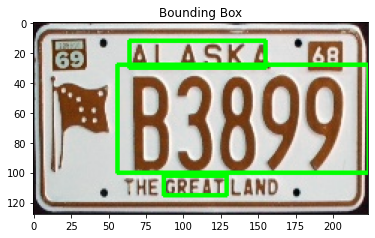

In [7]:
# import the necessary packages
import numpy as np
import time
from imutils.object_detection import non_max_suppression

min_confidence = 0.8
model = "/kaggle/input/frozen-east-text-detection/frozen_east_text_detection.pb"

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(model)

def normalizeImg(image, newSize = (320, 320)):
    (H, W) = image.shape[:2]
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = newSize
    rW = W / float(newW)
    rH = H / float(newH)
    # resize the image and grab the new image dimensions
    image_norm = cv2.resize(image, (newW, newH))
    (H, W) = image_norm.shape[:2]

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    return image_norm, H,W, rW,rH

def bounding_boxes(scores,geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    return non_max_suppression(np.array(rects), probs=confidences), confidences

image_norm, H,W, rW,rH = normalizeImg(image)
blob = cv2.dnn.blobFromImage(image_norm, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

boxes,confidences  = bounding_boxes(scores, geometry)
# boxes = np.array(rects)
# remove the bounding boxes that are too narrow or too short
boxes = [box for box in boxes if (box[2]-box[0]) > 50]

# make sure the largetest bounding box is fully expended horizontally
boxes = sorted(boxes, key=lambda box: (box[2]-box[0])*(box[3]-box[1]))
startX, startY, endX, endY = boxes[-1]
startX = 0 if startX > W/4 else startX
endX = W if endX < 3*W/4 else endX
boxes[-1] = (startX, startY, W, endY)
    
orig = image.copy()
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# draw the bounding box on the image
	cntImage = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
 
show_image(cntImage, 'Bounding Box')

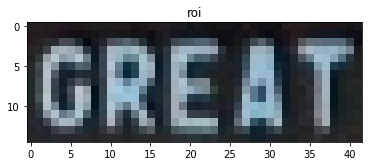

GREAT

[INFO] text detection took 0.146497 seconds


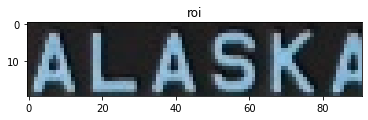

ALASK&¢

[INFO] text detection took 0.155336 seconds


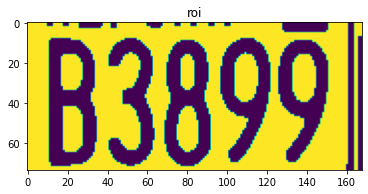

B3899|

[INFO] text detection took 0.141537 seconds


In [8]:
import time
# extract the text from boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    sx = int(startX * rW)
    sy = int(startY * rH)
    ex = int(endX * rW)
    ey = int((endY+5) * rH)
    # extract the region of interest
    roi = image[sy:ey, sx:ex]
    roi = blur_thresh(roi) if endY - startY > 50 else roi
    roi = denoise(roi) if endY - startY > 50 else roi
    roi = 255 - roi 
    plt.imshow(roi)
    plt.title('roi')
    plt.show()
    # configuration setting to convert image to string.
    config = ('-l eng --psm 6') # eng is English, psm 6 is for a single uniform block of text
    # now feeding image to tesseract
    start = time.time()
    det = pytesseract.image_to_string(roi, config=config)
    end = time.time()
    print(det)
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

## Easy OKR
EasyOCR consists of three components, The three main components of EasyOCR, are feature extraction, sequence labeling, and decoding.
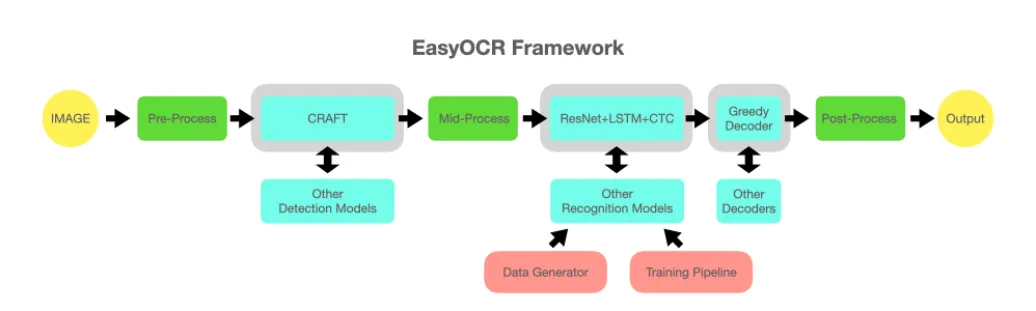
* feature extraction: deep learning models such as ResNet and VGG are used to create a set of features that can be utilized for additional analysis.
* sequence labeling: Long Short-Term Memory (LSTM) networks are uesed to interpret the extracted features’ sequential context.
* decoding: decodes and transcribes the labeled sequences into the actual recognized text using the Connectionist Temporal Classification (CTC) algorithm. 

please refer to [easy ocr comprehensive guide](https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168) for details.

In [9]:
%%capture
!pip install easyocr

[INFO] text detection took 5.410176 seconds
ALASKA
68
B3899 
THE GREAT Land


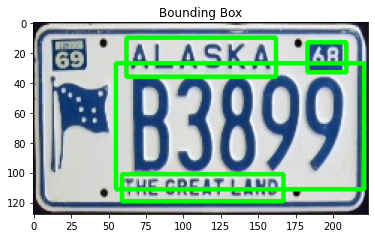

In [10]:
import easyocr
import cv2
import time
import matplotlib.pyplot as plt

path = "../input/us-license-plates-image-classification/new plates/test/ALASKA/1.jpg"
image = cv2.imread(path)
reader = easyocr.Reader(['en'])
start = time.time()
results = reader.readtext(image)
end = time.time()

# show timing information on text detection and recognition
print("[INFO] text detection took {:.6f} seconds".format(end - start))

for result in results:
    print(result[1])

for (bbox, text, prob) in results:
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'Bounding Box')

Better than tesseract, easy OCR doens't need extra preprocessing on the image and is able to catch more price bounding box and get more accurate result with even less time!

In [11]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  0% | 10% |


## Keras OCR
Keras is another state-of-art OCR platform which provides out-of-the-box OCR models and an end-to-end training pipeline to build new OCR models.

Since Tensorflow(AI framework behind Keras OCR) will occupy most of GPU memory, we will not run it otherwise the rest of code will failed on OOM(Out-Of) just paste the code and typical result below. 
```python
import keras_ocr
import matplotlib.pyplot as plt
import cv2
import time

# Pipeline setup
pipeline = keras_ocr.pipeline.Pipeline()

# Load an image
path = "/kaggle/input/us-license-plates-image-classification/new plates/test/ALASKA/1.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Start timing
start_time = time.time()

# Use the pipeline to detect and recognize text
prediction_groups = pipeline.recognize([image])

# End timing
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Text detection and recognition took {elapsed_time:.6f} seconds")

# Function to display images with annotations
def display_image(image, predictions):
    fig, ax = plt.subplots(figsize=(10, 10))
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

# Display results
for predictions in prediction_groups:
    display_image(image, predictions)
```
Welcome to try it out in your own environment as code and you will probably get following result.
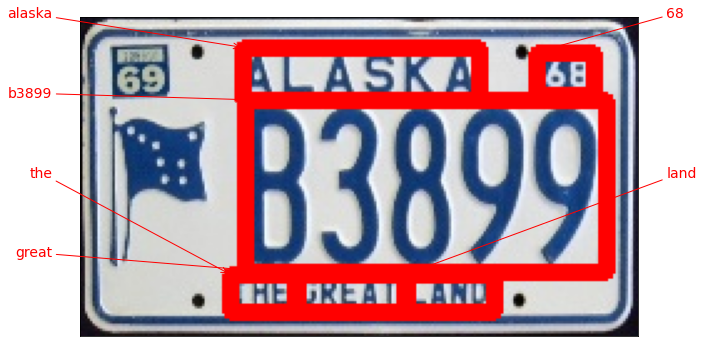

# Compare the performance between above main-stream OCR framework

## compare with the benchmark of cocotext
CocoText is a well-recognized benchmark to analyze the accuracy and efficiency of OCRs. 
We will use 

In [12]:
%%capture
!pip install keras-ocr

In [13]:
# loading the coco-text dataset
import os
img_num = 100
benchmarking_dir = './benchmarking/cocotext'
os.makedirs(benchmarking_dir, exist_ok=True)
import keras_ocr
dataset, (labels, images_dir) = keras_ocr.datasets.get_cocotext_recognizer_dataset(
    split='val',
    cache_dir='.',
    limit=img_num,
    return_raw_labels=True,
    legible_only=False,
    english_only=False
)
val_ids = list(labels['imgs'])
val_filenames = [labels['imgs'][cocoid]['file_name'] for cocoid in val_ids]
print(val_ids[:10])
print(val_filenames[:5])

Looking for ./coco-text/cocotext.v2.zip


['343992', '95243', '480851', '535732', '204714', '149280', '339589', '223888', '528080', '192497']
['COCO_train2014_000000343992.jpg', 'COCO_train2014_000000095243.jpg', 'COCO_train2014_000000480851.jpg', 'COCO_train2014_000000535732.jpg', 'COCO_train2014_000000204714.jpg']


In [14]:
import time
import json
import tqdm
import io
import os
import cv2

In [15]:
resized_images_dir = os.path.join(images_dir,"resized")
os.makedirs(resized_images_dir, exist_ok=True)

newH = 480  #240
newW = 600  #300

#normalize images to normalized folder
resized_ratio = {}
dimensions = []
for filename in val_filenames[:img_num]:
    image = cv2.imread(os.path.join(images_dir,filename))
    (H, W) = image.shape[:2]
    dimensions.append([H,W])
    image_norm, H,W, rW,rH = normalizeImg(image,(newW, newH))
    assert H == newH 
    assert W == newW
    cv2.imwrite(os.path.join(resized_images_dir,filename), image_norm)
    resized_ratio[filename] = (rW,rH)

# print average diemention of images to make the 
print("average dimention of images:")
np.mean(dimensions,axis=0,keepdims=True)

average dimention of images:


array([[471.58, 592.1 ]])

In [16]:
# Tesseract OCR
tess_annotations = {}
tess_timer = {}
start = time.time()
# for filename in tqdm.tqdm(val_filenames, desc='Getting Tesseract annotations'):
for step in tqdm.tqdm(range(0, len(val_filenames))):
    filename = val_filenames[step]

    image_path = os.path.join(images_dir, filename) 
    image = cv2.imread(image_path)    
    image_norm, H,W, rW,rH = normalizeImg(image)
    blob = cv2.dnn.blobFromImage(image_norm, 1.0, (W, H),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    boxes,confidences  = bounding_boxes(scores, geometry)
    # loop over the bounding boxes
    tess_annotations[filename] = []
    for index in range(0,len(boxes)):
        box = boxes[index]
        (startX, startY, endX, endY) = box
        # scale the bounding box coordinates to origal image
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int((endY+5) * rH) 
        roi = image[startY:endY, startX:endX]
        try:
            text = pytesseract.image_to_string(roi, config=config)
            tess_annotations[filename].append({
                'text': text,
                'vertices': [[startX,startY],[endX,startY],[endX,endY],[startX,endY]]
            })
        except Exception as e:
            #TODO: log the exceptions
#             print(e)
#             print(filename)
#             print("box=",box,"&conf=",confidences[index])
            continue
    if(step%10 == 0):
        end = time.time()
        tess_timer[step] = end - start
        
# keep track of ending time
end = time.time()
tess_timer[len(val_filenames)] = end-start

with open(os.path.join(benchmarking_dir, 'tess_annotations.json'), 'w') as f:
    f.write(json.dumps(tess_annotations))

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [17]:
# Easy OCR non-batch mode
import easyocr
reader = easyocr.Reader(['en'])

easyocr_annotations = {}

easy_timer = {}
start = time.time()
for step in tqdm.tqdm(range(0, len(val_filenames))):
    counter = step + 1
    filename = val_filenames[step]
    image_path = os.path.join(resized_images_dir, filename)
    image = cv2.imread(image_path)

    result = reader.readtext(image)

    if(0 == step%10):
        end = time.time()
        easy_timer[step] = end-start

    easyocr_annotations[filename] = []
    if result:
        (rW,rH) = resized_ratio[filename]
        # The first entry is always the full document annotation so we skip it.
        for (bbox, text, prob) in result:
            (tl, tr, br, bl) = bbox
            
            # scale back the bounding box to original size
            tl = (int(tl[0])*rW, int(tl[1])*rH)
            tr = (int(tr[0])*rW, int(tr[1])*rH)
            br = (int(br[0])*rW, int(br[1])*rH)
            bl = (int(bl[0])*rW, int(bl[1])*rH)

            easyocr_annotations[filename].append({
                'text': text,
                'vertices': [tl,tr,br,bl]
            })
# keep track of ending time
end = time.time()
easy_timer[len(val_filenames)] = end-start

with open(os.path.join(benchmarking_dir, 'easyocr_annotations.json'), 'w') as f:
    f.write(json.dumps(easyocr_annotations))

100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


In [18]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 | 23% | 13% |


In [19]:
# Easy OCR batch mode
import easyocr
reader = easyocr.Reader(['en'])

batch_size = 20  # Define batch size
easyocr_batch_annotations = {}

easy_batch_timer = {}
start = time.time()

for step in tqdm.tqdm(range(0, len(val_filenames), batch_size)):
    counter = (step + 1) * batch_size
    current_filenames = val_filenames[step:step+batch_size]

    # Batch process images
    batch_images = [os.path.join(resized_images_dir, filename) for filename in current_filenames]
    # resize all images to the same size for processing
    results = reader.readtext_batched(batch_images)

    if (0 == counter % batch_size):
        end = time.time()
        easy_batch_timer[counter] = end - start

    for filename, result in zip(current_filenames, results):
        easyocr_batch_annotations[filename] = []
        (rW,rH) = resized_ratio[filename]
        if result:
            # The first entry is always the full document annotation so we skip it.
            for (bbox, text, prob) in result:
                (tl, tr, br, bl) = bbox
                # scale back the bounding box to original size
                tl = (int(tl[0])*rW, int(tl[1])*rH)
                tr = (int(tr[0])*rW, int(tr[1])*rH)
                br = (int(br[0])*rW, int(br[1])*rH)
                bl = (int(bl[0])*rW, int(bl[1])*rH)
                easyocr_batch_annotations[filename].append({
                    'text': text,
                    'vertices': [tl,tr,br,bl]
                })

# keepin track of ending time
end = time.time()
easy_batch_timer[len(val_filenames)] = end - start

with open(os.path.join(benchmarking_dir, 'easyocr_annotations_batch.json'), 'w') as f:
    f.write(json.dumps(easyocr_batch_annotations))

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


In [20]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 | 32% | 85% |


In [21]:
# free gpu memory， only effective on pytorch
import gc
gc.collect()

import torch
try:
    reader
except NameError:
    reader_exists = False
else:
    reader_exists = True
if reader_exists:
    del reader
torch.cuda.empty_cache()

gpu_usage()

| ID | GPU | MEM |
------------------
|  0 | 92% |  6% |


In [22]:
keras_ocr_annotations = {}

import keras_ocr
step_size = 10
scale = 2
pipeline = keras_ocr.pipeline.Pipeline(scale=scale)
keras_timer = {}
start = time.time()
for step in tqdm.tqdm(range(0, len(val_filenames), step_size)):
    current_filenames = val_filenames[step:step+step_size]
    prediction_groups = pipeline.recognize([
      os.path.join(images_dir, filename) for filename in current_filenames
    ])
    if(0 == step % step_size): 
        end = time.time()
        keras_timer[step] = end-start
    for filename, predictions in zip(current_filenames, prediction_groups):
        keras_ocr_annotations[filename] = [
            {
                'text': text, 'vertices': box.tolist()
            } for text, box in predictions
        ]
# keep track of ending time
end = time.time()
keras_timer[len(val_filenames)] = end-start

with open(os.path.join(benchmarking_dir, f'keras_ocr_annotations_scale_{scale}.json'), 'w') as f:
    f.write(json.dumps(keras_ocr_annotations))

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


100%|██████████| 10/10 [01:19<00:00,  7.98s/it]


In [23]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  0% | 96% |


In [24]:
import numpy as np
import string

ground_truth_annotations = {
    filename: [
        {
            'vertices': np.array(ann['mask']).reshape(-1, 2),
            'text': ann['utf8_string'],
            'ignore': (
                ann['language'] != 'english' or
                ann['legibility'] != 'legible'
            )
        } for ann in [labels['anns'][str(annIdx)] for annIdx in labels['imgToAnns'][val_ids[id_index]]]
    ]
    for id_index, filename in enumerate(val_filenames)
}
score_kwargs = {
    'iou_threshold': 0.4,
    'similarity_threshold': 0.5,
    'translator': str.maketrans(string.ascii_uppercase, string.ascii_lowercase, string.punctuation),
    'true': ground_truth_annotations
}

for provider, annotations_file in [
    ('Tesseract', 'tess_annotations.json'),
    ('EasyOCR', 'easyocr_annotations.json'),
    ('EasyOCR(Batch)', 'easyocr_annotations_batch.json'),
    ('Keras (scale=2)', 'keras_ocr_annotations_scale_2.json'),
]:
    with open(os.path.join(benchmarking_dir, annotations_file), 'r') as f:
        annotations = json.loads(f.read())
    results, (precision, recall) = keras_ocr.evaluation.score(pred=annotations, **score_kwargs)
    print(f'{provider}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}')

Tesseract, Precision: 0.06, Recall: 0.03
EasyOCR, Precision: 0.53, Recall: 0.23
EasyOCR(Batch), Precision: 0.54, Recall: 0.24
Keras (scale=2), Precision: 0.55, Recall: 0.66


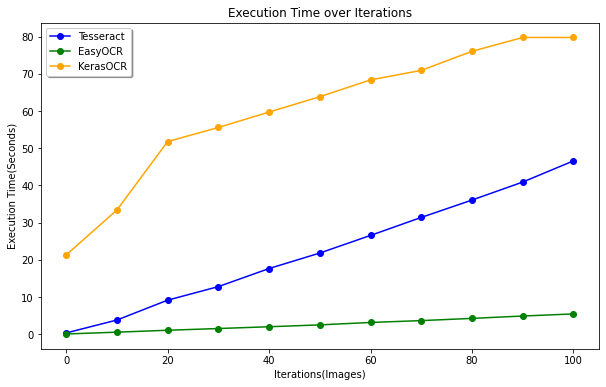

In [25]:
# plot performance along iterations
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, img_num, int(img_num/10) + 1)
#print(x)
y_tess = [tess_timer[ix] for ix in x]
y_easy = [easy_timer[ix] for ix in x]
y_keras = [keras_timer[ix] for ix in x]

plt.figure(figsize=(10, 6))
plt.xlabel('Iterations(Images)')
plt.ylabel('Execution Time(Seconds)')
plt.title('Execution Time over Iterations')

plt.plot(x, y_tess, '-o', color = 'blue')
plt.plot(x, y_easy, '-o', color = 'green')
plt.plot(x, y_keras, '-o', color = 'orange')
plt.legend(('Tesseract', 'EasyOCR', 'KerasOCR'),
           loc='upper left', shadow=True)
plt.show()

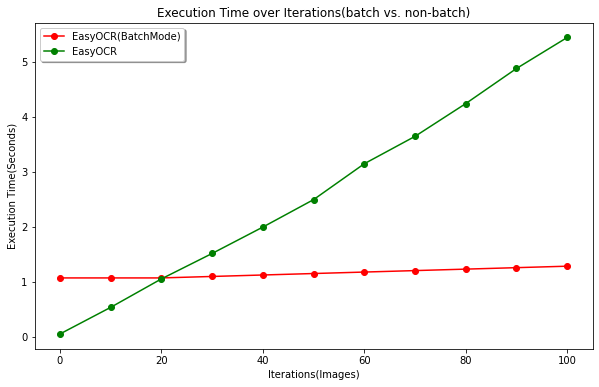

In [26]:
# plot performance along iterations
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 100, 11)
#print(x)
# use interp to in case step is too big
y_easy_batch = [np.interp(ix, list(easy_batch_timer.keys()), list(easy_batch_timer.values())) for ix in x]
y_easy = [easy_timer[ix] for ix in x]

plt.figure(figsize=(10, 6))
plt.xlabel('Iterations(Images)')
plt.ylabel('Execution Time(Seconds)')
plt.title('Execution Time over Iterations(batch vs. non-batch)')

plt.plot(x, y_easy_batch, '-o', color = 'red')
plt.plot(x, y_easy, '-o', color = 'green')
plt.legend(('EasyOCR(BatchMode)', 'EasyOCR'),
           loc='upper left', shadow=True)
plt.show()

### Optimize the performance via parallel computing
#### utilize GPU if possible
Classic tesseract and openCV* doesn't support GPU version: https://github.com/tesseract-ocr/tesseract/issues/4129 

| Method    | GPU support? | processing time(image/sec) | Remark        |
|-----------|--------------|----------------------------|---------------|
| Tesseract | N            | 2~3                        |               |
| Easy OCR  | Y            | 18~20                      | non-batchmode |
| Keras OCR | Y            | 1~2                        | batchmode     |

- opencv doesn't support GPU by-default
- 3.07=10(images/iter)/3.26(sec/iter)

Tesseract obviously performs worst in accuracy, it almost failed every test in complext situations like coco-text. The accuracy issue will be further analyzed using a much eaiser task: license plate recognition. Since it doesn't support GPU acceleration, the processing time is based on performance utilizting all 4 cpus.

Easy OCR performs amazingly in both accuracy and efficiency. It should be the first choice for real-life OCR task. 

Keras OCR performs best in accuracy but worst in efficiency. It needs more fine-tuning or customiztion if utilizing in real-life scenarios. Besides, Keras OCR depends on Tensorflow, which obviously takes more GPU memory and cause OOM excpet which forces us to shrink the resized images to circumvent the issue. 

#### batch processing images if possible
One key technique to increase the performance of GPU is to keep GPU as busy as possible. So batch processing come to play. 
Through bach processing, Easy OCR can even boost its performance theoratically, we did some experiment to enable batch mode of easy OCR. Batch mode performs astonishing better in the cost of much higher GPU memory usage compared to non-batch mode which is already the best performing among all OCR framework. 

#### fine-tuning batch size
Though increasing batch size can make higher utiliztion of GPU, it has limit. If we increase the batch size over thresthold, it will consumes all GPU memory and got OOM(Out-of-Memory) exception. So a careful balance should be made on batch size, model size(which relates to the accuracy of performance) and execution memory uasge, which depends on the model structure/architecure and model pipeline. The topic is too large for this proejct, but we can do try and error under existing hardware constraints, e.g. if we increase the batch size of Keras OCR a little bit, say set to 15, we will get OOM after a few interations, so 10 will be the optimal number. 

## Performance analysis using us-license-plates dataset
Why classic tesseract doesn't perform well on COCO text benchmark is partly due to COCO-texts appears on different scene. We can re-evaluate its performance on clear front-end license plates dataset. 

One challenge is that the license plate dataset donen't have **ground_truth_annotations** of license number. To encoutner the challenge, we use following rules for evaluation:

* Accuracy
    * only license number, which has the largest bounding box, is counted for accuracy evaluation
    * we take either results of EasyOCR or Keras OCR as ground_truth.
* Efficiency(in terms of execution time)
    * try to monitor the performance of OCRs on every 10 images similar to what we did for coco-text version.
    * observer how much complexity of task(clear license plate/us-license plates vs. different scenes/Coco text) will affect the execution time. 

In [27]:
import os
benchmarking_dir = './benchmarking/us-license-plate'
os.makedirs(benchmarking_dir, exist_ok=True)

In [28]:
# load datasets into variables
image_map = {}
import os
for root, dirs, files in os.walk("/kaggle/input/us-license-plates-image-classification/plates/test"):
    if files:
        image_map[root] = files
#     print(root)
#     print(dirs)
#     print(files)
#     print("===========")

# print(image_map)

val_filenames = []
# select first to val_filenames
for root, files in image_map.items():
    for file in files[0:2]:
        val_filenames.append(os.path.join(root,file))
print(val_filenames[0:5])
print(len(val_filenames))

['/kaggle/input/us-license-plates-image-classification/plates/test/KENTUCKY/5.jpg', '/kaggle/input/us-license-plates-image-classification/plates/test/KENTUCKY/1.jpg', '/kaggle/input/us-license-plates-image-classification/plates/test/WISCONSIN/5.jpg', '/kaggle/input/us-license-plates-image-classification/plates/test/WISCONSIN/1.jpg', '/kaggle/input/us-license-plates-image-classification/plates/test/OKLAHOMA/5.jpg']
100


With use of tesseract, we will extract the text from the mage.


In [29]:
# using easy okr to get the ground truth 
import easyocr
import numpy as np
reader = easyocr.Reader(['en'])

easyocr_annotations = {} 

easy_timer = {}
start = time.time()
for step in tqdm.tqdm(range(0, len(val_filenames)), desc='Getting EasyOCR annotations'):
    filename = val_filenames[step]
    image_path = os.path.join(images_dir, filename) 
    image = cv2.imread(image_path)
    
    texts = reader.readtext(image)
       
    if(0 == step%10):
        end = time.time()
        easy_timer[step] = end-start
    
    vertices = []
    lp_text = ""
    area = 0.0
    # The first entry is always the full document annotation so we skip it.
    for (bbox, text, prob) in texts:
        (tl, tr, br, bl) = bbox
        tl = (int(tl[0]), int(tl[1]))
        tr = (int(tr[0]), int(tr[1]))
        br = (int(br[0]), int(br[1]))
        bl = (int(bl[0]), int(bl[1]))
        # calculate the area
        (dx, dy)= tuple(np.subtract(tl, br))
        if(dx*dy>area):
            area = dx * dy
            lp_text = text
            vertices = (tl, tr, br, bl)
    easyocr_annotations[filename] = []    
    easyocr_annotations[filename].append({
        'text': text,
        'vertices': vertices
    })
# keep track of ending time
end = time.time()
easy_timer[len(val_filenames)] = end-start

with open(os.path.join(benchmarking_dir, 'easyocr_annotations.json'), 'w') as f:
    f.write(json.dumps(easyocr_annotations))

Getting EasyOCR annotations: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


In [30]:
# Tesseract OCR
tess_annotations = {}
tess_timer = {}
start = time.time()
# for filename in tqdm.tqdm(val_filenames, desc='Getting Tesseract annotations'):
for step in tqdm.tqdm(range(0, len(val_filenames))):
    filename = val_filenames[step]

    image_path = os.path.join(images_dir, filename) 
    image = cv2.imread(image_path)    
    image_norm, H,W, rW,rH = normalizeImg(image)
    blob = cv2.dnn.blobFromImage(image_norm, 1.0, (W, H),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    boxes,confidences  = bounding_boxes(scores, geometry)
    # take the largetest bounding box as license plate number
    boxes = sorted(boxes, key=lambda box: (box[2]-box[0])*(box[3]-box[1]))
    startX, startY, endX, endY = boxes[-1]

    tess_annotations[filename] = []
 
    # scale the bounding box coordinates to origal image
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int((endY+5) * rH) 
    roi = image[startY:endY, startX:endX]
    try:
        text = pytesseract.image_to_string(roi, config=config)
        tess_annotations[filename].append({
            'text': text,
            'vertices': [[startX,startY],[endX,startY],[endX,endY],[startX,endY]]
        })
    except Exception as e:
        #TODO: log the exceptions
        print(e)
#             print(filename)
#             print("box=",box,"&conf=",confidences[index])
        
    if(step%10 == 0):
        end = time.time()
        tess_timer[step] = end - start
        
# keep track of ending time
end = time.time()
tess_timer[len(val_filenames)] = end-start

with open(os.path.join(benchmarking_dir, 'tess_annotations.json'), 'w') as f:
    f.write(json.dumps(tess_annotations))

 12%|█▏        | 12/100 [00:07<00:49,  1.78it/s]

tile cannot extend outside image


 41%|████      | 41/100 [00:23<00:30,  1.96it/s]

tile cannot extend outside image


 51%|█████     | 51/100 [00:29<00:24,  1.97it/s]

tile cannot extend outside image


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [31]:
import numpy as np
import string

# set easy ocr annocation as ground_truth
ground_truth_annotations = easyocr_annotations

score_kwargs = {
    'iou_threshold': 0.4,
    'similarity_threshold': 0.5,
    'translator': str.maketrans(string.ascii_uppercase, string.ascii_lowercase, string.punctuation),
    'true': ground_truth_annotations
}

for provider, annotations_file in [
    ('Tesseract', 'tess_annotations.json'),
    ('EasyOCR', 'easyocr_annotations.json'),
]:
    with open(os.path.join(benchmarking_dir, annotations_file), 'r') as f:
        annotations = json.loads(f.read())
    results, (precision, recall) = keras_ocr.evaluation.score(pred=annotations, **score_kwargs)
    print(f'{provider}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}')

Tesseract, Precision: 0.31, Recall: 0.25
EasyOCR, Precision: 1.0, Recall: 1.0


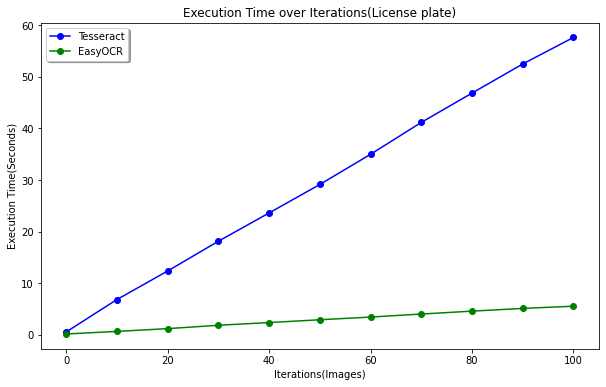

In [32]:
# plot performance along iterations
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 100, 11)
#print(x)
y_tess = [tess_timer[ix] for ix in x]
y_easy = [easy_timer[ix] for ix in x]

plt.figure(figsize=(10, 6))
plt.xlabel('Iterations(Images)')
plt.ylabel('Execution Time(Seconds)')
plt.title('Execution Time over Iterations(License plate)')

plt.plot(x, y_tess, '-o', color = 'blue')
plt.plot(x, y_easy, '-o', color = 'green')
plt.legend(('Tesseract', 'EasyOCR'),
           loc='upper left', shadow=True)
plt.show()

### Reassessing the Tesseract on License plate 
After the experiment, we can find:
* Accuracy: Although Tesseract performs not well(accuracy barely 30% of state-of-art OCRs )  on license plate(easier) tasks, we verified that its accuracy improves noticeably than challenging COCO-text benchmark in both accuracy(0.3 vs. 0.06/0.5) and recall(0.25 vs. 0.03/0.24) by approximately 2~3 times!
* Performance: Tesseract doen's gain noticible improvement in the performance in easier task, 

# 